## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs from different atlases
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [8]:
import sys
import numpy as np
import pandas as pd
import itertools

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [9]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_aparc_lh_thickness_file = 'lh.aparc.thickness.table.test1'
fs60_aparc_rh_thickness_file = 'rh.aparc.thickness.table.test1' #34 ROIs
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
fs60_glasser_lh_thickness_file = 'lh.glasser.thickness.table.test1' #180 ROIs per hemi
fs60_glasser_rh_thickness_file = 'rh.glasser.thickness.table.test1'


# Surface Area
# fs60_aparc_lh_SA_file = 'aparc_lh_SA_table.test1'
# fs60_aparc_rh_SA_file = 'aparc_rh_SA_table.test1'
# fs60_aparc2009_lh_SA_file = 'lh.aparc.a2009.SA.table.test1'
# fs60_aparc2009_rh_SA_file = 'rh.aparc.a2009.SA.table.test1'


### Global Vars

In [10]:
subject_ID_col = 'SubjID'

### Load data

In [11]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc'
fs60_aparc_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_lh_thickness_file, delim_whitespace=True)
fs60_aparc_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_aparc_lh_thickness_data.shape,fs60_aparc_rh_thickness_data.shape))
fs60_aparc_thickness_data_std = standardize_fs60_data(fs60_aparc_lh_thickness_data, 
                                                      fs60_aparc_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


# Glasser
aparc = 'aparc.Glasseratlas'
fs60_glasser_lh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_lh_thickness_file, delim_whitespace=True)
fs60_glasser_rh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 glasser data l: {}, r: {}'.format(fs60_glasser_lh_thickness_data.shape,fs60_glasser_rh_thickness_data.shape))
fs60_glasser_thickness_data_std = standardize_fs60_data(fs60_glasser_lh_thickness_data,
                                                          fs60_glasser_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_glasser_thickness_data_std.shape))


shape of fs60 aparc data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 aparc data (1047, 71)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)
shape of fs60 glasser data l: (1047, 182), r: (1047, 182)
shape of left and right merge fs6.0 df (1047, 363)
shape of stdized fs60 aparc data (1047, 363)


### Create master dataframe

In [12]:
data_dict = {'aparc' : fs60_aparc_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std,
            'Glasser' : fs60_glasser_thickness_data_std}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# Shift to (0 and 1 instead of 1 and 2 for statsmodels)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP']-1
useful_demograph['SEX'] = useful_demograph['SEX']-1

_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

### Compare ML performance 

In [13]:
covar_continuous_cols = [] #'AGE_AT_SCAN'
covar_cat_cols = ['SEX','SITE_ID'] #'SEX','SITE_ID','DX_GROUP'

model_type = 'classification'

if model_type.lower() == 'regression':
    outcome_col = 'AGE_AT_SCAN'
    model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
else: 
    outcome_col = 'DX_GROUP'
    #model = svm.SVC(kernel='linear')
    model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

ml_perf_dict = {}

start_time_ML = time.time()
for atlas in data_dict.keys():
    start_time_atlas = time.time()
    print('Atlas {}'.format(atlas))
    master_df = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    roi_cols = master_df.filter(regex='^L|R_', axis=1).columns
    #master_df['pipeline'] = np.tile(atlas,len(master_df))
    ml_perf = getMLModelPerf(master_df,roi_cols, covar_continuous_cols,covar_cat_cols,outcome_col,model_type,model)
    ml_perf_dict[atlas] = ml_perf
    
    print('time to process atlas {:4.3f}s \n'.format(time.time()-start_time_atlas))
    

print('time to process ML {:4.3}s'.format(time.time()-start_time_ML))


Atlas Glasser
Using 2 col for 21 cat covar
Data shapes X (1047, 381), y 1047 ([552, 495])
Using classification model with perf metric roc_auc
 Perf mean:0.537, sd:0.058
time to process atlas 10.343s 

Atlas aparc
Using 2 col for 21 cat covar
Data shapes X (1047, 89), y 1047 ([552, 495])
Using classification model with perf metric roc_auc
 Perf mean:0.534, sd:0.057
time to process atlas 5.413s 

Atlas Destrieux
Using 2 col for 21 cat covar
Data shapes X (1047, 169), y 1047 ([552, 495])
Using classification model with perf metric roc_auc
 Perf mean:0.542, sd:0.058
time to process atlas 7.525s 

time to process ML 23.3s



### Compare statsmodels performance 

In [14]:
covar_continuous_cols = ['AGE_AT_SCAN']
covar_cat_cols = ['SEX','SITE_ID']
outcome_col = 'DX_GROUP' #AGE_AT_SCAN #DX_GROUP #SEX
stat_model = 'logit' #ols #logit
stat_perf_dict = {}
save_sm_perf = False

for atlas in data_dict.keys():
    mr_data_df = data_dict[atlas]
    roi_cols = list(mr_data_df.filter(regex='^L|R_', axis=1).columns)
    master_df = pd.merge(useful_demograph,mr_data_df[[subject_ID_col]+ roi_cols],on=subject_ID_col)
    master_df['atlas'] = np.tile(atlas,len(master_df))
    
    #Save standarized df to csv for outlier detection
    #master_df.to_csv(fs60_dir + '{}_standarized.csv'.format(atlas))
    
    sm_perf = getStatModelPerf(master_df,roi_cols,covar_continuous_cols,covar_cat_cols,outcome_col,stat_model)
    stat_perf_dict[atlas] = sm_perf
    print('Shape of the stats_models results df {}'.format(sm_perf.shape))
    print('Top 10 significant regions:\n {}'.format(sm_perf.sort_values(by=['p_val']).head(10)))
    print('')
    
if save_sm_perf:
    save_path = '{}atlas_sm_perf_{}.pkl'.format(results_dir,outcome_col)
    print('Saving sm_perf dictionary at \n{}'.format(save_path))
    with open(save_path, 'wb') as handle:
        pickle.dump(stat_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


Example statsmodel run:
 DX_GROUP ~ R_p24_ROI + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (360, 3)
Top 10 significant regions:
             roi     t_val     p_val
183    R_V2_ROI -4.670495  0.000003
0      L_V1_ROI -4.626443  0.000004
3      L_V2_ROI -4.345992  0.000014
341   R_31a_ROI -3.559711  0.000371
169  L_p10p_ROI -3.351552  0.000804
174    L_A4_ROI -3.054145  0.002257
180    R_V1_ROI -2.910705  0.003606
4      L_V3_ROI -2.867549  0.004137
92    L_OFC_ROI -2.778298  0.005464
285  R_PoI2_ROI  2.769220  0.005619

Example statsmodel run:
 DX_GROUP ~ R_insula + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (68, 3)
Top 10 significant regions:
                       roi     t_val     p_val
45              R_lingual -3.640070  0.000273
19        L_pericalcarine -3.586604  0.000335
11              L_lingual -3.527087  0.000420
3                L_cuneus -3.052464  0.002270
12  L_medialorbitofrontal -2.945105  0.003228
9      L_latera

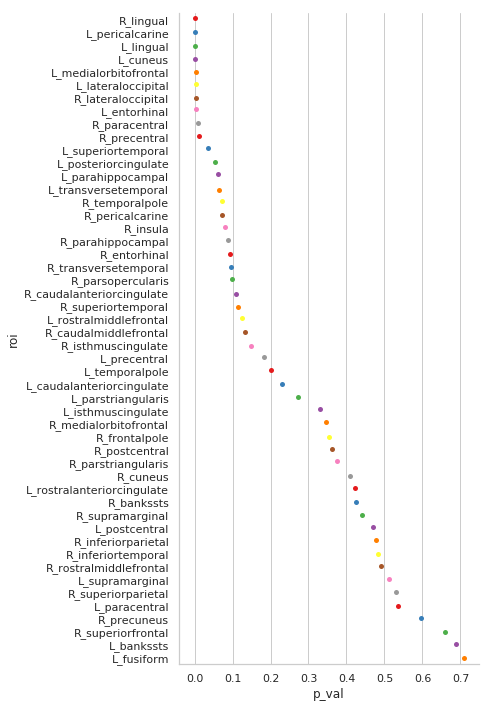

In [15]:
# Plots
aparc = 'aparc' #'Destrieux', 'aparc','Glasser'
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.7)
    #g.set(xscale="log");